# Documentation

**Notebook Prerequisites:** This notebook relies upon the train and test datasets created in the preparation phase.

<br>

**Notebook Comments:** Code blocks that result in data being overwritten, such as model building and sample generation, have been toggled off with Boolean checks by default. Data backups are produced where appropriate.

While efforts have been taken to reduce memory consumption, certain parts of the code will result in heavy memory use. If running extended hyperparameter tuning cycles, it is advisable to run them in a separate runtime, so that the available resources are not exhausted prior to their completion. The previously mentioned Boolean flags can assist with this.

Random seeds have been set in order to promote result reproducibility, although factors such as library versions and GPU use can introduce degrees of non-determinism.

<br>

**Modelling Purpose:** The purpose of this code is to build and train a cGAN and use that model to synthesise minority class instances. Augmentation with this output is intended to help alleviate severe class imbalance.

<br>

**Modelling Approach:** Due to the difficult nature of training GAN based models, non-exhaustive hyperparameter tuning will be used to produce a set of near-optimum settings for use in this specific context. Synthetic data produced by the resulting cGAN will be inspected at set epochs in order to select the best sample for augmentation.

<br>

**Modelling Overview:**
* 1.0 Configuration
* 2.0 Hyperparameter Tuning
* 3.0 Modelling
* 4.0 Synthesis
* 5.0 Exports

<br>

**Note:** The project cells are intended to be run sequentially in Google Colab. Coding adjustments will be needed to use the code in other environments or to employ non-standard paths through the presented cell order.

# 1.0 Configuration

### | 1.1 Imports

In [ ]:
import gc
from google.colab import drive
import joblib
from keras import backend as K
from keras.layers import (BatchNormalization, Concatenate,
                          Dense, Dropout, Input, LeakyReLU)
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
from scipy.stats import ks_2samp
import seaborn as sns
import shutil
from sklearn.manifold import TSNE
try:  # check for skopt as not present by default
    from skopt import gp_minimize
    from skopt.space import Real, Integer
except ImportError:
    !pip install scikit-optimize
    from skopt import gp_minimize
    from skopt.space import Real, Integer
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # control the tf warning level
import warnings
warnings.filterwarnings('ignore', category=UserWarning,  # suppress hdf5 warning
                        module='keras.*', message='.*HDF5 file via.*')

### | 1.2 Model Functions

In [ ]:
# cgan build functions:

# create a generator model
def build_g(features, condition, noise, l2r, alpha, neurons, layers):

    # define input layers and merge
    input_noise = Input(shape=(noise,))
    input_label = Input(shape=(condition,))
    input_merged = Concatenate()([input_noise, input_label])

    # first layer with regularisation normalisation and leakyrelu
    g = Dense(neurons, kernel_regularizer=l2(l2r))(input_merged)
    g = BatchNormalization()(g)
    g = LeakyReLU(alpha)(g)

    # add additional layers
    for _ in range(layers - 1):
        g = Dense(neurons, kernel_regularizer=l2(l2r))(g)
        g = BatchNormalization()(g)
        g = LeakyReLU(alpha)(g)

    # output layer with linear activation and regularisation
    output = Dense(features, activation='linear', kernel_regularizer=l2(l2r))(g)

    return Model([input_noise, input_label], output)

# create a discriminator model
def build_d(features, condition, l2r, alpha, neurons, layers):

    # input layer using all x_train and y_train features
    input_values = Input(shape=(features + condition,))

    # first layer with regularisation Dropout and leakyrelu
    d = Dense(neurons, kernel_regularizer=l2(l2r))(input_values)
    d = Dropout(0.5)(d)
    d = LeakyReLU(alpha)(d)

    # add additional layers
    for _ in range(layers - 1):
        d = Dense(neurons, kernel_regularizer=l2(l2r))(d)
        d = Dropout(0.5)(d)
        d = LeakyReLU(alpha)(d)

    # output layer with sigmoid activation
    data_validity = Dense(1, activation='sigmoid', kernel_regularizer=l2(l2r))(d)

    return Model(input_values, data_validity)

# create a cgan model
def build_c(g, d):

    # prevent discriminator updating through the combined model
    d.trainable = False

    # extract input and output tensors and merge
    input_noise, input_label = g.input
    output_generator = g.output
    output_sample = Concatenate(axis=1)([output_generator, input_label])

    # pass combined tensor for discriminator assessment
    data_validity = d(output_sample)

    # create and compile the cgan with adam and bce
    c = Model([input_noise, input_label], data_validity)
    c.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

    return c


# cgan train functions:

# train the generator as part of a cgan
def train_g(c, noise, labels, valid):

    # generate an array of noise
    input_noise = generate_noise(noise, labels.shape[0])

    # train and retrieve generator loss values
    generator_loss = c.train_on_batch([input_noise, labels], valid)

    return generator_loss

# train the discriminator
def train_d(g, d, noise, real, fake, labels, valid):

    # generate batch of synthetic samples
    input_noise = generate_noise(noise, real.shape[0])
    fake_samples = g.predict([input_noise, labels], verbose=0)

    # labels to real and fake samples
    real_samples = np.hstack((real, labels))
    fake_samples = np.hstack((fake_samples, labels))

    # train discriminator on both samples
    loss_real = d.train_on_batch(real_samples, valid)
    loss_fake = d.train_on_batch(fake_samples, fake)

    # calculate the average discriminator loss
    discriminator_loss = 0.5 * np.add(loss_real, loss_fake)

    return discriminator_loss

# train the cgan
def train_c(g, d, c, X, y, noise, batch, epochs, patience, interval, checkpoint):

    # loss tracking variables
    d_loss = []
    g_loss = []
    d_best = float('inf')    # initalised so first losses seen are an improvement
    g_best = float('inf')
    improvement_plateau = 0  # early stop epoch count without improvement
    ideal_loss = 0.693       # midpoint for random binary discriminator guessing

    # label smoothing for added training stability
    real_labels = np.ones((batch, 1)) * 0.9   # unrelated to minority label 1
    fake_labels = np.zeros((batch, 1)) + 0.1  # unrelated to majority label 0

    # train until set epoch maximum is reached
    for epoch in range(epochs):

        # random minority class batch selection
        real_samples, real_condition = random_batch(X_minority, y_minority, batch)

        # train models and track loss results
        d_values = train_d(g, d, noise, real_samples, fake_labels,
                           real_condition, real_labels)
        g_values = train_g(c, noise, real_condition, real_labels)
        d_loss.append(d_values)
        g_loss.append(g_values)

        # early stop boolean check
        g_best, improvement_plateau, stop_training = stop_check(
            g_values, g_best, improvement_plateau, epoch, patience)
        if stop_training:
            break

        # check if progress should be printed
        print_loss(epoch, epochs, g_values, d_values, ideal_loss, interval)

        # check if model should be saved
        save_checkpoint(epoch, checkpoint, g)

    # display loss graph at the end of model training
    plot_losses(epoch, g_loss, d_loss, interval)
    plt.show()

    return g_loss, d_loss


# cgan coordinating function:

# coordinate cgan model building and training
def execute_train(parameters, features, condition, X, y,
                  epochs, patience, interval, checkpoint):

    # unpack parameters from passed list
    noise, batch, lr, l2, alpha, beta, neurons, glayers, dlayers = parameters

    # build generator
    generator = build_g(features, condition, noise, l2, alpha, neurons, glayers)

    # build discriminator using bce for binary real fake classification
    discriminator = build_d(features, condition, l2, alpha, neurons, dlayers)
    discriminator.compile(optimizer=Adam(lr, beta), loss='binary_crossentropy')

    # build cgan using above models
    cgan = build_c(generator, discriminator)

    # train cgan and retrieve loss values
    g_loss, d_loss = train_c(generator, discriminator, cgan, X, y, noise,
                                 batch, epochs, patience, interval, checkpoint)

    return g_loss, d_loss, generator, discriminator, cgan


# cgan build and train helper functions:

# create random noise array
def generate_noise(noise, batch):

    # create a batch of values within the given dimension
    noise_array = np.random.normal(0, 1, (batch, noise))

    return noise_array

# early stop check
def stop_check(g_loss, g_best, improvement_plateau, epoch, patience):

    # either update best generator loss or increment plateau tracker
    if g_loss < g_best:
        g_best = g_loss
        improvement_plateau = 0
    else:
        improvement_plateau += 1

    # early stop if plateau exceeds patience
    stop_training = False
    if improvement_plateau > patience:
        print(f'! Early stop at epoch {epoch}')
        stop_training = True

    return g_best, improvement_plateau, stop_training

# model checkpoint saving
def save_checkpoint(epoch, checkpoint, g):

    # save if checkpoint value exists and is reached
    if checkpoint != 0 and epoch % checkpoint == 0:
        save_path = drive_prefix + 'models/'
        g.save(save_path + f'generator_{epoch:04d}.h5')  # left pad name with 0s

# print training loss values
def print_loss(epoch, epochs, g_loss, d_loss, ideal_loss, interval):

    # print if interval is between range and a multiple has been reached
    if epoch > 0 and epoch < (epochs + 1) and epoch % interval == 0:

        # formatted terminal loss output
        print(f'  {epoch:04d}/{epochs:04d}\t'  # left pad with 0s for alignment
              f'G: {g_loss:.4f}\t'
              f'D: {d_loss:.4f}\t'
              f'Ideal: {d_loss - ideal_loss:.4f}')

# pass fixed loss information to generalised line graph function
def plot_losses(epoch, g_loss, d_loss, interval):

    # titles axis labels and legend
    title = 'Generator and Discriminator Loss'
    xlabel = 'Epoch'
    ylabel = 'Loss'
    glabel = 'Generator'
    dlabel = 'Discriminator'

    # plot loss graph
    fig, ax = plt.subplots(figsize=(plot_size(0.5, 1)))
    plot_line(g_loss, d_loss, ax, title, xlabel, ylabel, glabel, dlabel)

# select random samples
def random_batch(X, y, batch):

    # define random batch indicies within constraints
    batch_selection = np.random.randint(0, X.shape[0], batch)

    # filter instances by random batch indicies
    real_samples = X[batch_selection]
    real_labels = y[batch_selection]

    return real_samples, real_labels


# bayesian optimisation specific functions:

# allow additional parameters to be passed to the testing coordinating function
def optimisation_parameters(parameters):

    # will return last generator loss value to the optimisation function
    return loss_testing(parameters, feature_count, condition_count, X_minority,
                        y_minority, bo_calls, bo_epochs, bo_patience, bo_interval)

# coordinate input and output of a testing iteration
def loss_testing(parameters, features, condition, X, y,
                 calls, epochs, patience, interval):

    # trim floats and print confirmation of new testing parameters
    formatted_parameters = ', '.join([f"{param:.6f}" if isinstance(
        param, float) else str(param) for param in parameters])
    print('\n* New Parameters: ')
    print('  ' + str(formatted_parameters))
    print('  Loss values at set epoch interval:')

    # optimisation function only requires generator loss value returned
    g_losses, _, _, _, _ = execute_train(parameters, features, condition,
                                         X, y, epochs, patience, interval, 0)

    # force clear resources due to resource limitations
    del _
    K.clear_session()
    gc.collect();

    # return last generator loss to optimisation function through wrapper
    return g_losses[-1]

# save optimisation data to file
def optimisation_checkpoint(result):

    # build full path with global drive_prefix value
    full_path = drive_prefix +  'tuning/'

    # pickle optimisation data to set file
    joblib.dump(result, full_path + 'optimisation data.pkl')


# cgan specific data processing functions:

# extract a given class from dataset
def extract_minority(X, y, condition):

    # identify minority indicies
    minority_indicies = np.where(y == condition)[0]

    # filter minority only and reshape as needed
    X_minority = X.iloc[minority_indicies].values
    y_minority = y.iloc[minority_indicies].values.reshape(-1, 1)

    # return dataframes as arrays
    return X_minority, y_minority

### | 1.3 Visualisation Functions

In [ ]:
# graph consistency functions:

# use a consistent graph style with an optional legend and colourbar
def apply_style(ax, title, xlabel, ylabel, legend=False, colourbar=False):

    # base colours
    grey_bg = '#f5f5f5'
    grey_grid = '#dadada'
    grey_borders = '#282828'

    # retrieve font sizes
    medium, large = font_size()

    # label formatting
    ax.set_title(title, fontsize=large, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=medium, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=medium, fontweight="bold")

    # x tick label formatting
    for label in ax.get_xticklabels():
        label.set_fontsize(medium)

    # y tick label formatting
    for label in ax.get_yticklabels():
        label.set_fontsize(medium)

    # optional legend formatting
    if legend == True:
        graph_legend = ax.legend(loc='upper right')
        frame = graph_legend.get_frame()
        for text in graph_legend.get_texts():
            text.set_fontsize(medium)

    # optional colorbar font size to match style
    if colourbar == True:
        cbar = ax.collections[0].colorbar
        for label in cbar.ax.yaxis.get_ticklabels():
            label.set_fontsize(medium)

    # graph appearance
    ax.grid(color=grey_grid, which="both")
    ax.set_facecolor(grey_bg)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_edgecolor(grey_borders)

    # minimise overlaps
    plt.tight_layout()

# return consistent visualisation colours
def data_colours():

    # sequential visually equidistant colour scheme
    colour_one = '#ffa600'    # yellow
    # colour_two = '#dc0062'  # pink unsued
    colour_three = '#002E6E'  # blue

    return colour_one, colour_three

# return consistent font sizes
def font_size():

    medium = 9  # intended for labels
    large = 10  # intended for titles

    return medium, large


# graph plotting functions:

# plot a two line graph
def plot_line(data_one, data_two, ax, title, xlabel, ylabel, label_one, label_two):

    # set data colours
    colours = list(data_colours())

    # create the graph on the subplot
    ax.plot(data_one, color=colours[1], label=label_one)
    ax.plot(data_two, color=colours[0], label=label_two)

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel, legend=True)

# plot a two data t-SNE graph
def plot_tsne(data_one, data_two, ax, title, label_one, label_two,
              xlabel='Dimension One', ylabel='Dimension Two'):

    # set data colours
    colours = list(data_colours())

    # calculate t-SNE embeddings for all data
    data_one = TSNE(n_components=2, random_state=random_seed).fit_transform(data_one)
    data_two = TSNE(n_components=2, random_state=random_seed).fit_transform(data_two)

    # create the graphs on the subplots
    ax.scatter(data_one[:, 0], data_one[:, 1], color=colours[1],
               s=20, alpha=1, label=label_one)
    ax.scatter(data_two[:, 0], data_two[:, 1], color=colours[0],
               s=20, alpha=0.33, label=label_two)  # low alpha on layered data

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel, legend=True)

# plot a heatmap
def plot_heatmap(data, ax, title, xlabel, ylabel, xticks,
                 cmap='plasma', annotate=False):

    # set column names
    data.columns = xticks

    # create the graph
    sns.heatmap(data, ax=ax, cmap=cmap, annot=annotate)

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel, colourbar=True)

# plot a bar chart with optional log scale
def plot_bar(data_one, data_two, data_three, ax, title,
             xticks, xlabel, ylabel, log_scale=False):

    # set data colours
    colours = list(data_colours())

    # create the graph on the subplot
    ax.bar(xticks[0], data_one, color=colours[1], log=log_scale)
    ax.bar(xticks[1], data_two, color=colours[0], log=log_scale)
    ax.bar(xticks[2], data_three, color=colours[0], log=log_scale)

    # apply the defined style
    apply_style(ax, title, xlabel, ylabel)

# scale plot size to number of graphs
def plot_size(rows, columns):

    # reasonable display size for a single graph
    width = 5.5
    height = 4.5

    # scaling factor
    scaling = 0.55

    # increase plot size if multiple graphs
    horizontal = ((width * scaling) * (columns - 1)) + width
    vertical = ((height * scaling) * (rows - 1)) + height

    # inverted output order to match plotting function inputs
    return horizontal, vertical

### | 1.4 Data Loading

In [ ]:
# data loading code:

# mount google drive and provide project root
drive.mount('/content/drive/', force_remount=True)
drive_prefix = '/content/drive/MyDrive/Credit Card Synthetic Data/'

# load processed training data
X_train = pd.read_pickle(drive_prefix + 'data/processed/X_train.pkl')
y_train = pd.read_pickle(drive_prefix + 'data/processed/y_train.pkl')

# force display of all dataframe columns to aid inspection
pd.set_option("display.max_columns", None)


# data processing code:

# dataset information variables
feature_count = X_train.shape[1]         # x_train feature count
column_names = X_train.columns.tolist()  # extract x_train column names
condition_count = 1                      # y_train feature count

# filter only the minority class
X_minority, y_minority = extract_minority(X_train, y_train, condition_count)

# delete unneeded data and force garbage collection
del X_train, y_train
gc.collect();

Mounted at /content/drive/


### | 1.5 Reproducibility

In [ ]:
# random seed code:

# base and derived random seeds
random_seed = 42
random.seed(random_seed)         # for python based calculations
np.random.seed(random_seed)      # for numpy based calculations
tf.random.set_seed(random_seed)  # for tensorflow based calculations

# 2.0 Hyperparameter Tuning

### | 2.1 Data Integrity Check

In [ ]:
# class check code:

# check minority instances match previous output
print('X_minority Instances = ' + str(len(X_minority)))
print('y_minority Instances = ' + str(len(y_minority)))

X_minority Instances = 369
y_minority Instances = 369


**Observations:**
* Data load and minority class filtering successful as counts match processed values.

### | 2.2 Search Space

In [ ]:
# retrieving information code:

# paths for existing data and backup
tuning_path = drive_prefix + 'tuning/optimisation data.pkl'
backup_path = tuning_path.replace('optimisation data.pkl',
                                  'backup/optimisation data backup.pkl')

# set number of previously completed tuning iterations
if os.path.exists(tuning_path):
    bo_count = len((joblib.load(tuning_path)).x_iters)
else:
    bo_count = 0


# optimisation configuration code:

# bayesian optimisation iteration settings
bo_target = 50                   # target iterations
bo_epochs = 5000                 # epochs per iteration
bo_patience = bo_epochs * 0.333  # early stop epoch value
bo_interval = bo_epochs / 10     # loss information print interval

# bayesian optimisation search space
bo_noise = [50, 150]      # noise dimension
bo_batch = [200, 250]     # batch sample
bo_lr = [0.0001, 0.001]   # learning rate
bo_l2 = [0.00001, 0.005]  # regularisation
bo_alpha = [0.05, 0.2]    # leakyrelu alpha
bo_beta = [0.4, 0.9]      # adam beta
bo_neurons = [100, 500]   # layer neurons
bo_glayers = [2, 5]       # generator layers
bo_dlayers = [2, 5]       # discriminator layers

**Observations:**
* These search values are informed by the results of previous broader tuning cycles.

**Actions:**
* Use the refined search space in tuning cycles upto at least the target iteration.

### | 2.3 Bayesian Optimisation

$ Beginning Bayesian Hyperparameter Optimisation

> Data From Previous 60 Cycles Loaded

* New Parameters: 
  130, 209, 0.000602, 0.000408, 0.116875, 0.449987, 284, 3, 2
  Loss values at set epoch interval:
  0500/5000	G: 1.2444	D: 0.6982	Ideal: 0.0052
  1000/5000	G: 1.2037	D: 0.6922	Ideal: -0.0008
  1500/5000	G: 1.1124	D: 0.6734	Ideal: -0.0196
  2000/5000	G: 1.1218	D: 0.6670	Ideal: -0.0260
  2500/5000	G: 1.1025	D: 0.6784	Ideal: -0.0146
  3000/5000	G: 1.0793	D: 0.6628	Ideal: -0.0302
  3500/5000	G: 1.0884	D: 0.6580	Ideal: -0.0350
  4000/5000	G: 1.1008	D: 0.6425	Ideal: -0.0505
  4500/5000	G: 1.1171	D: 0.6638	Ideal: -0.0292


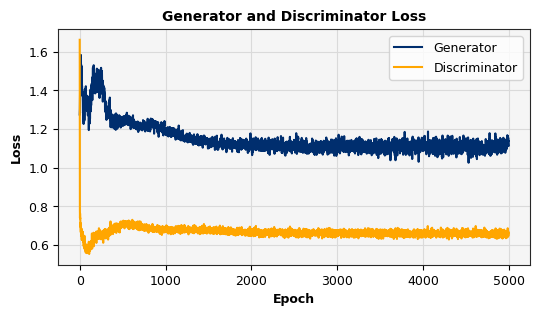


* New Parameters: 
  50, 248, 0.000525, 0.000946, 0.136695, 0.508700, 342, 3, 2
  Loss values at set epoch interval:
  0500/5000	G: 1.4740	D: 0.7238	Ideal: 0.0308
  1000/5000	G: 1.2178	D: 0.6878	Ideal: -0.0052
  1500/5000	G: 1.0853	D: 0.7071	Ideal: 0.0141
  2000/5000	G: 0.8805	D: 0.6192	Ideal: -0.0738
  2500/5000	G: 0.9500	D: 0.7021	Ideal: 0.0091
  3000/5000	G: 0.9506	D: 0.7052	Ideal: 0.0122
  3500/5000	G: 0.9024	D: 0.6947	Ideal: 0.0017
! Early stop at epoch 3582


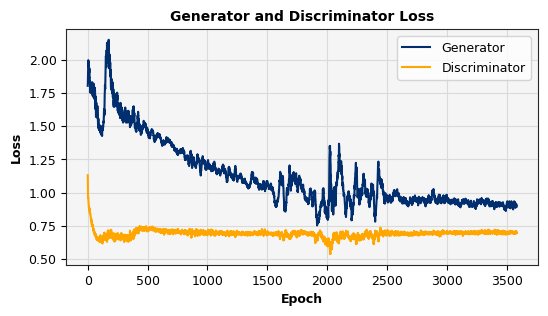


* New Parameters: 
  147, 231, 0.000939, 0.000227, 0.174310, 0.454886, 385, 5, 2
  Loss values at set epoch interval:
  0500/5000	G: 1.2577	D: 0.6975	Ideal: 0.0045
  1000/5000	G: 1.2013	D: 0.6892	Ideal: -0.0038
  1500/5000	G: 1.1736	D: 0.6677	Ideal: -0.0253
! Early stop at epoch 1775


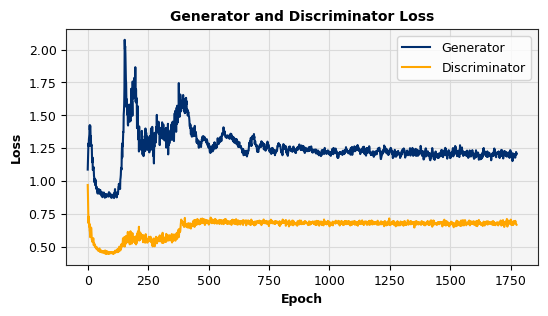


* New Parameters: 
  112, 212, 0.000234, 0.000662, 0.187203, 0.585943, 259, 2, 5
  Loss values at set epoch interval:
  0500/5000	G: 1.5264	D: 1.0821	Ideal: 0.3891
  1000/5000	G: 1.2659	D: 0.9047	Ideal: 0.2117
  1500/5000	G: 1.0820	D: 0.7846	Ideal: 0.0916
  2000/5000	G: 1.0242	D: 0.7339	Ideal: 0.0409
  2500/5000	G: 0.9973	D: 0.7050	Ideal: 0.0120
  3000/5000	G: 0.9570	D: 0.6898	Ideal: -0.0032
  3500/5000	G: 0.9761	D: 0.6874	Ideal: -0.0056
  4000/5000	G: 1.0145	D: 0.6709	Ideal: -0.0221
! Early stop at epoch 4468


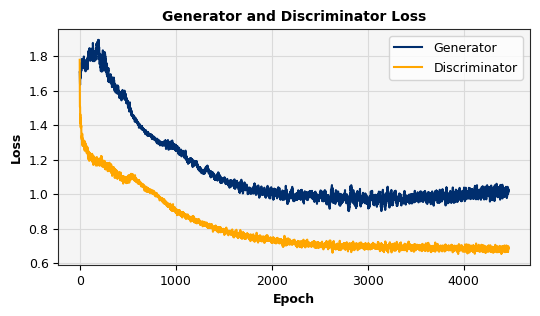


* New Parameters: 
  141, 231, 0.000115, 0.001040, 0.146418, 0.583990, 299, 4, 4
  Loss values at set epoch interval:
  0500/5000	G: 2.0268	D: 1.3087	Ideal: 0.6157
  1000/5000	G: 1.6158	D: 1.0873	Ideal: 0.3943
  1500/5000	G: 1.0981	D: 0.8905	Ideal: 0.1975
  2000/5000	G: 1.0025	D: 0.8889	Ideal: 0.1959
  2500/5000	G: 0.9300	D: 0.8256	Ideal: 0.1326
  3000/5000	G: 0.8341	D: 0.7699	Ideal: 0.0769
  3500/5000	G: 0.7279	D: 0.6665	Ideal: -0.0265
  4000/5000	G: 0.7471	D: 0.7418	Ideal: 0.0488
  4500/5000	G: 0.7609	D: 0.7215	Ideal: 0.0285


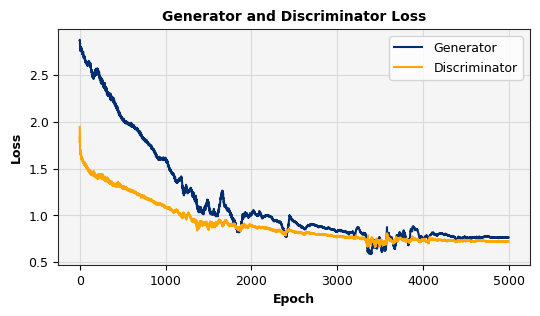


* New Parameters: 
  76, 235, 0.000424, 0.000038, 0.105014, 0.835972, 388, 2, 4
  Loss values at set epoch interval:
  0500/5000	G: 0.9167	D: 0.6567	Ideal: -0.0363
  1000/5000	G: 1.1699	D: 0.5983	Ideal: -0.0947
  1500/5000	G: 1.3771	D: 0.5681	Ideal: -0.1249
! Early stop at epoch 1669


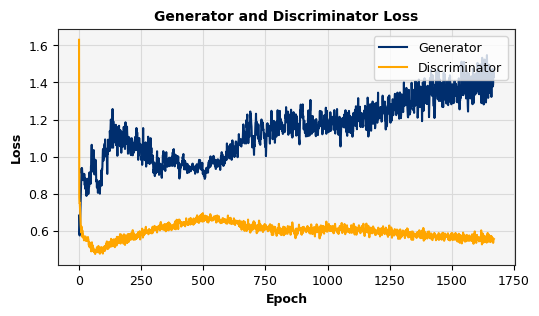


* New Parameters: 
  96, 204, 0.000673, 0.000027, 0.145424, 0.635251, 212, 5, 4
  Loss values at set epoch interval:
  0500/5000	G: 0.9523	D: 0.5972	Ideal: -0.0958
  1000/5000	G: 0.8685	D: 0.6430	Ideal: -0.0500
  1500/5000	G: 1.1710	D: 0.6037	Ideal: -0.0893
! Early stop at epoch 1733


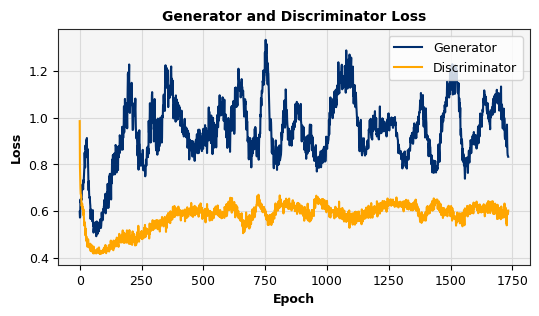


* New Parameters: 
  146, 229, 0.000482, 0.000144, 0.174563, 0.439941, 411, 4, 4
  Loss values at set epoch interval:
  0500/5000	G: 1.2768	D: 0.7383	Ideal: 0.0453
  1000/5000	G: 1.2862	D: 0.6719	Ideal: -0.0211
  1500/5000	G: 1.3975	D: 0.5921	Ideal: -0.1009
! Early stop at epoch 1718


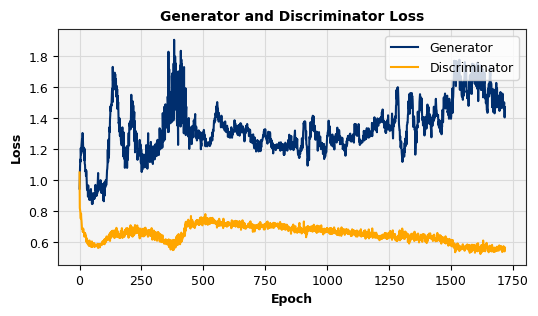


* New Parameters: 
  56, 208, 0.000321, 0.000961, 0.127685, 0.457856, 284, 3, 4
  Loss values at set epoch interval:
  0500/5000	G: 1.5634	D: 0.9401	Ideal: 0.2471
  1000/5000	G: 1.2102	D: 0.7586	Ideal: 0.0656
  1500/5000	G: 1.1012	D: 0.7044	Ideal: 0.0114
  2000/5000	G: 1.0654	D: 0.5507	Ideal: -0.1423
  2500/5000	G: 1.0329	D: 0.5753	Ideal: -0.1177
  3000/5000	G: 1.0361	D: 0.6683	Ideal: -0.0247
  3500/5000	G: 0.8404	D: 0.5023	Ideal: -0.1907
  4000/5000	G: 0.9942	D: 0.5074	Ideal: -0.1856
  4500/5000	G: 1.0393	D: 0.6548	Ideal: -0.0382


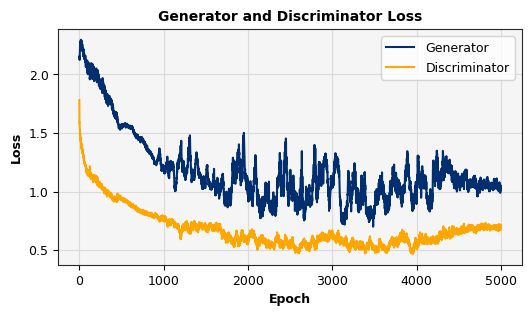


* New Parameters: 
  60, 232, 0.000104, 0.000045, 0.062509, 0.580513, 477, 4, 3
  Loss values at set epoch interval:
  0500/5000	G: 0.8475	D: 0.7261	Ideal: 0.0331
  1000/5000	G: 0.8708	D: 0.7298	Ideal: 0.0368
  1500/5000	G: 0.8392	D: 0.7258	Ideal: 0.0328
! Early stop at epoch 1749


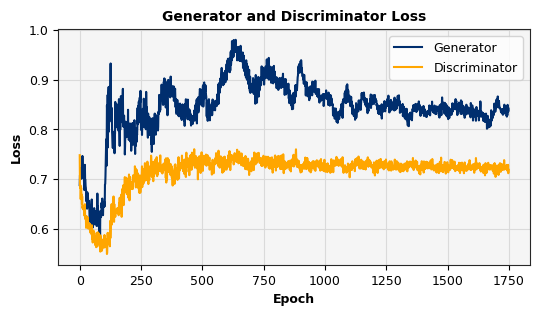

In [ ]:
# uncomment variable to force an additional optimisation cycle
bo_calls = bo_target - bo_count  # target iterations minus iterations completed
#bo_calls = 10

# starts a new optimisation cycle if set target hasnt been reached
if bo_calls > 0:


    # optimisation initalisation code:

    # set search space as a dictionary for passing to optimisation function
    optimisation_space = {
        'range_noise': Integer(bo_noise[0], bo_noise[1]),
        'range_batch': Integer(bo_batch[0], bo_batch[1]),
        'range_lr': Real(bo_lr[0], bo_lr[1], 'log-uniform'),
        'range_l2': Real(bo_l2[0], bo_l2[1], 'log-uniform'),
        'range_alpha': Real(bo_alpha[0], bo_alpha[1], 'uniform'),
        'range_beta': Real(bo_beta[0], bo_beta[1], 'uniform'),
        'range_neurons': Integer(bo_neurons[0], bo_neurons[1]),
        'range_glayers': Integer(bo_glayers[0], bo_glayers[1]),
        'range_dlayers': Integer(bo_dlayers[0], bo_dlayers[1])}

    # signal start of optimisation cycle
    print('$ Beginning Bayesian Hyperparameter Optimisation')


    # warm start code:

    # populate variables if data exists
    if os.path.exists(tuning_path):

        # copy data to backup path
        shutil.copy(tuning_path, backup_path)

        # load optimisation data and confirm warm start
        optimisation_data = joblib.load(tuning_path)
        x0 = optimisation_data.x_iters    # explored parameters
        y0 = optimisation_data.func_vals  # explored performance
        print('\n> Data From Previous ' +
              str(len(optimisation_data.x_iters)) + ' Cycles Loaded')

    else:
        # initialise and confirm cold start
        x0 = None
        y0 = None
        print('\n> No Previous Optimisation Data Found')


    # optimisation code:

    # begin optimisation iterations
    bo_result = gp_minimize(optimisation_parameters,  # target function
                      dimensions=list(optimisation_space.values()),  # search space
                      n_calls=bo_calls,
                      x0=x0,
                      y0=y0,
                      callback=[optimisation_checkpoint])  # checkpoint function


# optimisation complete code:

else:
    print('$ Optimisation Complete')
    print('\n>', bo_count, '/', bo_target, 'Target Tuning Cycles Completed')
    print('\n* Recommended Parameters', (joblib.load(tuning_path)).x)

**Observations:**
* Dimishing returns will inevitably effect further refinement cycles.

**Actions:**
* Accept optimsation function output as near-optimal hyperparameters rather than optimal.

* Start a fresh optimisation cycle if any input information changes.

# 3.0 Modelling

### | 3.1 Model Parameters

In [ ]:
# model paths code:

# set paths for model backup
checkpoint_path = drive_prefix + 'models/'
backup_path = checkpoint_path + 'backup/'


# model configuration code:

# base training on optimisation settings to allow comparison
training_epochs = bo_epochs * 2          # higher potential epoch limit
training_patience = bo_patience * 0.5    # more aggressive early stop
training_interval = bo_interval          # keep output consistent
training_checkpoint = training_interval  # synchronise backups with output

# load recent optimisation values as parameters
training_parameters = (joblib.load(drive_prefix + 'tuning/optimisation data.pkl')).x

**Observations:**
* cGAN training values derived from optimisation cycle settings to allow diagnostic comparisons.

**Actions:**
* Train the cGAN using the near-optimal values provided by the optimisation function.

### | 3.2 cGAN Training

$ Beginning cGAN Model Training

> Saving Checkpoints Every 500 Epochs 

* Bayesian Optimised Parameters: 118, 234, 0.000963, 0.000731, 0.114919, 0.900000, 319, 5, 2
  Loss values at set epoch interval:
  0500/10000	G: 1.6628	D: 0.5385	Ideal: -0.1545
  1000/10000	G: 1.7187	D: 0.6323	Ideal: -0.0607
  1500/10000	G: 1.2090	D: 0.5825	Ideal: -0.1105
  2000/10000	G: 1.1890	D: 0.6323	Ideal: -0.0607
  2500/10000	G: 1.1110	D: 0.6985	Ideal: 0.0055
  3000/10000	G: 0.8862	D: 0.6359	Ideal: -0.0571
  3500/10000	G: 0.7557	D: 0.6603	Ideal: -0.0327
  4000/10000	G: 0.7384	D: 0.6704	Ideal: -0.0226
  4500/10000	G: 0.7200	D: 0.7074	Ideal: 0.0144
  5000/10000	G: 0.6626	D: 0.5831	Ideal: -0.1099
  5500/10000	G: 0.5662	D: 0.6304	Ideal: -0.0626
  6000/10000	G: 0.6758	D: 0.6848	Ideal: -0.0082
! Early stop at epoch 6430


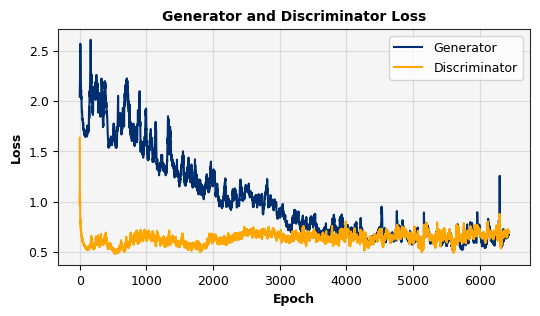

In [ ]:
# uncomment to start a new training cycle and overwrite existing backups
run_training = False
#run_training = True

if run_training == True:


    # model back up code:

    # list existing h5 files in directory
    existing_models = [f for f in os.listdir(checkpoint_path) if f.endswith('.h5')]

    # rename and move each existing model file into backup folder
    for model_file in existing_models:

        # construct paths and rename file
        model_path = os.path.join(checkpoint_path, model_file)
        backup_rename = model_file.replace('.h5', ' backup.h5')
        destination_path = os.path.join(backup_path, backup_rename)

        # move the backup file
        shutil.move(model_path, destination_path)


    # model training code:

    # announce training start and present formatted parameters
    parameter_string = [f"{int(param) if param.is_integer() else f'{param:.6f}'}"
                        if isinstance(param, float) else str(param)
                        for param in training_parameters]
    print('$ Beginning cGAN Model Training\n')
    print('> Saving Checkpoints Every', int(training_checkpoint), 'Epochs \n')
    print('* Bayesian Optimised Parameters:', ', '.join(parameter_string))
    print('  Loss values at set epoch interval:')

    # train cgan with checkpoint saving and ignoring returned values
    execute_train(training_parameters, feature_count, condition_count,
                  X_minority, y_minority, training_epochs, training_patience,
                  training_interval, training_checkpoint)


# training disabled code:

else:
    print('$ cGAN Training Disabled To Preserve Data')
    print('\n> Change Run_Training To True To Train A New Model')

**Observations:**
* Discriminator consistently close to the theoretical optimum loss shortly after beginning.

* Generator loss improves until 5500, then begins to spike before the early stop is triggered.

* The quality of the synthetic data is inconclusive from loss visualisation alone.

**Actions:**
* Synthesise data across multiple epoch checkpoints and inspect data quality.

# 4.0 Synthesis

### | 4.1 Synthesis Settings

In [ ]:
# listing checkpoints code:

# list available h5 models and sort by epoch number
model_files = [f for f in os.listdir(checkpoint_path) if f.endswith('.h5')]
model_files = sorted(model_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

# print all models available for clarity
print(len(model_files), 'Models Saved In Directory:')
for model in model_files:
    print('-', model)


# synthesis configuration code:

# data quantity and class label
synthetic_data = 1777   # added to the 369 existing minority gives a 99:1 ratio
synthetic_condition = condition_count

# create noise with same dimension used in model training
synthetic_noise = np.random.normal(0, 1, (synthetic_data, training_parameters[0]))

# set sample and backup paths
sample_path = drive_prefix + "data/samples/synthetic samples.pkl"
sample_backup = drive_prefix + "data/samples/backup/synthetic samples backup.pkl"

13 Models Saved In Directory:
- generator_0000.h5
- generator_0500.h5
- generator_1000.h5
- generator_1500.h5
- generator_2000.h5
- generator_2500.h5
- generator_3000.h5
- generator_3500.h5
- generator_4000.h5
- generator_4500.h5
- generator_5000.h5
- generator_5500.h5
- generator_6000.h5


**Observations:**
* Available models match the expected number given the triggered early stop of training.

* Augmentation would result in a 99:1 ratio, improved from 576:1.

* Ratio is sufficient to take the dataset out of the severe class imbalance range.

**Actions:**
* Generate samples and display using a dimension reduction for mode collapse assessment.

### | 4.2 Data Synthesis

$ Beginning Data Synthesis

> Processing High Sample Counts May Take Significant Time

* Creating 1777 instances for 13 models:


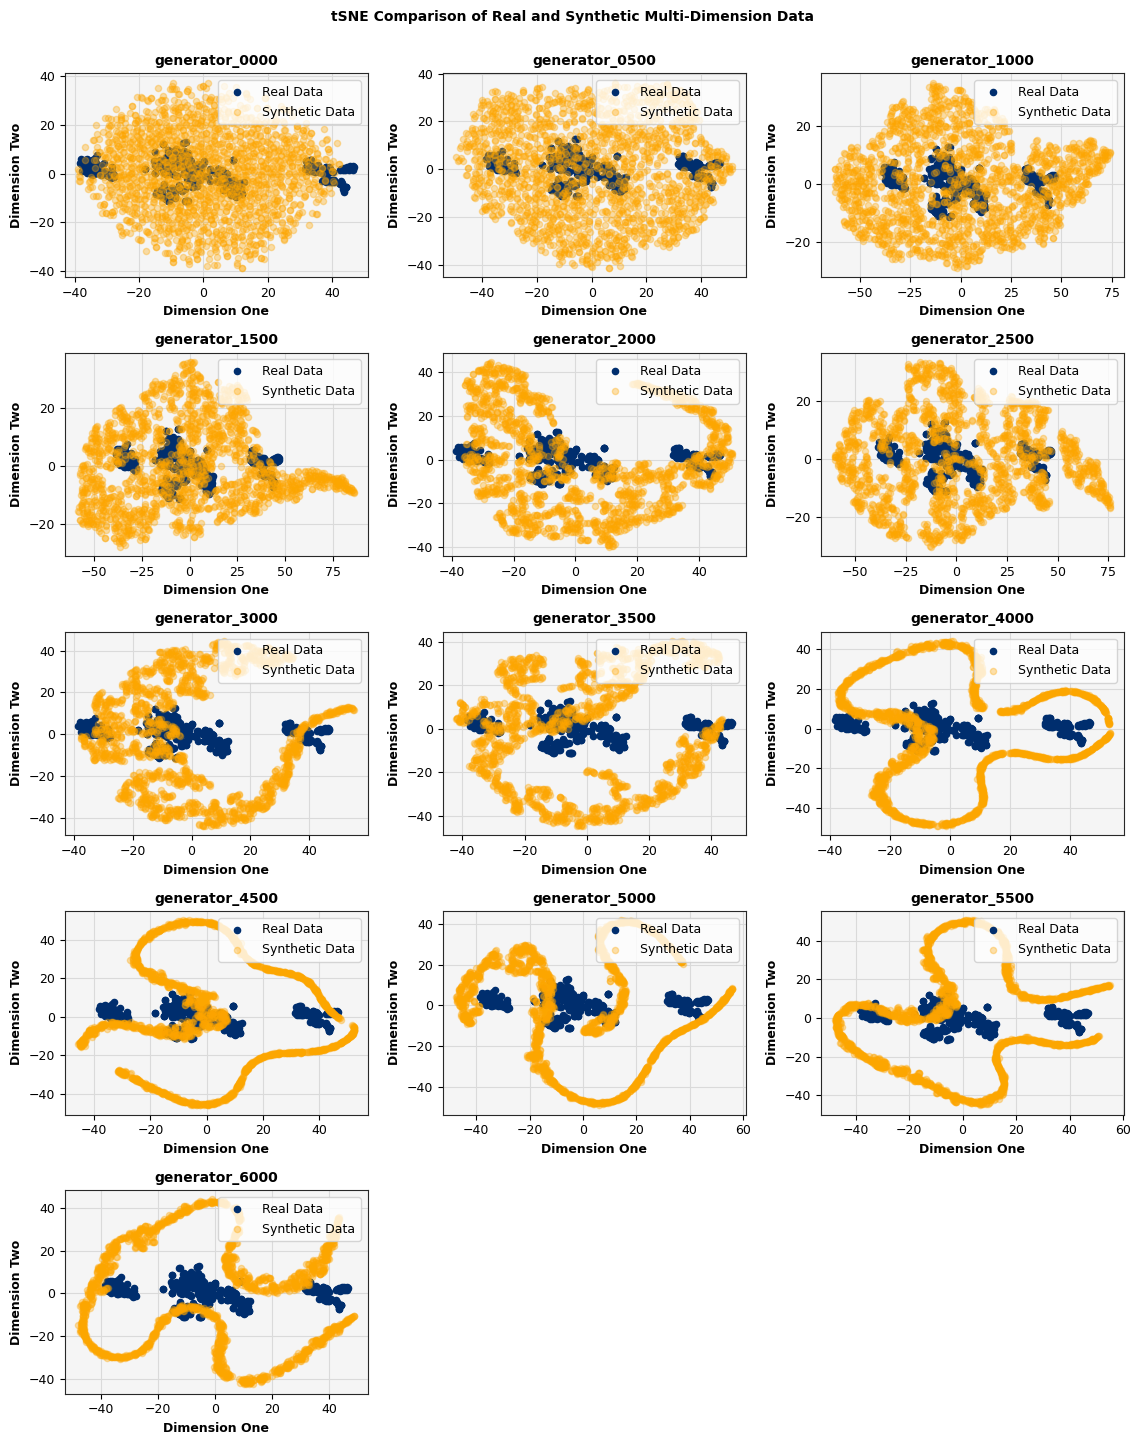

In [ ]:
# set to true to synthesise new samples and overwrite any existing data
new_samples = False
#new_samples = True

if new_samples == True:


    # combined visualisation code:

    # calculate rows required for intended plots
    model_count = len(model_files)
    column_count = 3
    row_count = int(np.ceil(model_count / column_count))

    # prepare figure for visualisation and flatten axes for iteration
    fig, axes = plt.subplots(row_count, column_count, figsize=(
        plot_size(row_count, column_count)))
    fig.suptitle("tSNE Comparison of Real and Synthetic Multi-Dimension Data",
                 fontsize=font_size()[1], fontweight="bold", y=1)
    axes = axes.ravel()


    # new sample generation code:

    # dictionary to hold dataframes of synthetic data
    sample_dataframes = {}

    # confirm synthesis start and show relevant values
    print('$ Beginning Data Synthesis')
    print('\n> Processing High Sample Counts May Take Significant Time')
    print('\n* Creating', synthetic_data, 'instances for', model_count, 'models:')

    # backup sample data if file exists
    if os.path.exists(sample_path):
        shutil.copy(sample_path, sample_backup)

    # load each model from the file list
    for idx, model_file in enumerate(model_files):

        # load model from constructed path
        generator_model = load_model(os.path.join(checkpoint_path, model_file))

        # generate appropriate class labels and synthesise data
        conditions = np.ones((synthetic_data, condition_count))
        generated_samples = generator_model.predict([synthetic_noise,
                                                     conditions], verbose=0)

        # store synthesised data in a dataframe and add to dictionary
        generated_df = pd.DataFrame(generated_samples, columns=column_names)
        sample_dataframes[model_file] = generated_df

        # save current dictionary iteration to file
        with open(sample_path, 'wb') as f:
            pickle.dump(sample_dataframes, f)


        # graphing code:

        # add model visualisation to the relevant subplot
        plot_tsne(X_minority, generated_df.values, axes[idx],
                  model_file[:-3], 'Real Data', 'Synthetic Data')

    # hide any unused axes for neatness
    for i in range(idx + 1, row_count * column_count):
        axes[i].axis('off')

    plt.show()


# training disabled code:

else:
    print('$ Sample Generation Disabled To Preserve Current Data')
    print('\n> Change New_Samples To True To Synthesise New Data')

**Observations:**
* Synthetic data increasingly fits real data patterns until epochs 1000 and 1500.

* Epoch 3000 appears to be the beginning of the mode collapse evident in epoch 4000 onwards.

**Actions:**
* Apply Kolmogorov-Smirnov tests to samples up to epoch 3000 for further evaluation.

### | 4.3 Model Refinement

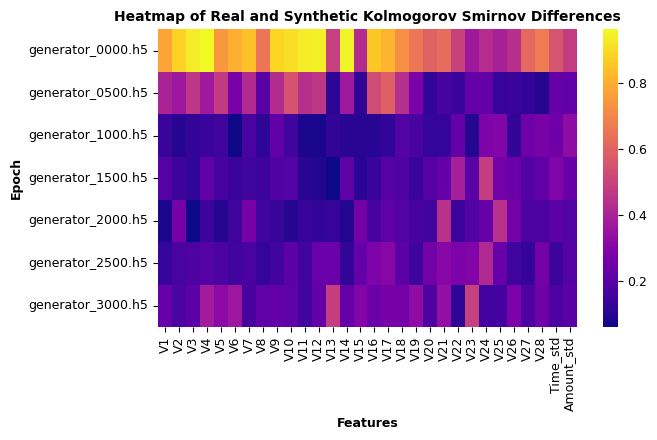

In [ ]:
# data processing code:

# specify which model begins to show mode collapse
try:
    cutoff_key = model_files[6]  # model upto epoch 3000
except IndexError:
    print('Error: Specified model is not in the list')

# remove any data produced by models after the cutoff
if cutoff_key in model_files:
    index = model_files.index(cutoff_key)
    retain_up_to_key = model_files[:index+1]
    sample_dataframes = {key: sample_dataframes[key]
                         for key in retain_up_to_key if key in sample_dataframes}

# flatten array for each feature
x_flat = {i: X_minority[:, i] for i in range(X_minority.shape[1])}

# kolmogorov smirnov statistic dataframe with set columns and float data types
ks_stat = pd.DataFrame(index=sample_dataframes.keys(),
                             columns=range(X_minority.shape[1]))
ks_stat = ks_stat.astype(float)


# kolmogorov smirnov calculation code:

# iterate over the dataframes and their features
for key, df in sample_dataframes.items():
    for feature in range(X_minority.shape[1]):

        # flatten the current feature
        df_flattened = df.iloc[:, feature].values

        # calculate and store the ks statistic in the dataframe
        ks_stat.at[key, feature] = ks_2samp(x_flat[feature], df_flattened)[0]


# visualisation code:

# create plot and display ks results as a heatmap
fig, ax = plt.subplots(figsize=(plot_size(1 ,1.5)))
plot_heatmap(ks_stat, ax, "Heatmap of Real and Synthetic Kolmogorov Smirnov Differences",
             "Features", "Epoch", column_names)
plt.show()

**Observations:**
* As expected, the earlier models fail to capture the real data details.

* Epoch 1000 appears to have the highest concentration of darkest values.

* Epoch 1000 appears to have the lowest concentration of brightest values.

* Theorised mode collapse beginning in epoch 3000 appears a valid assumption.

**Actions:**
* Use the samples from the epoch 1000 checkpoint model for data augmentation.

# 5.0 Exports

### | 5.1 Data Augmentation

In [ ]:
# set to true to augment training data and overwrite any existing data
augment_data = False
#augment_data = True

if augment_data == True:


    # augmentation code:

    # overwite sample variable to ensure latest samples
    with open(sample_path, 'rb') as file:
        sample_dataframes = pickle.load(file)

    # model samples to augment
    selected_epoch = '1000'
    selected_model = sample_dataframes['generator_' + selected_epoch + '.h5']

    # reload original training data for augmentation
    X_train = pd.read_pickle(drive_prefix + 'data/processed/X_train.pkl')
    y_train = pd.read_pickle(drive_prefix + 'data/processed/y_train.pkl')

    # concatenate dataset and series with synthetic data sample
    X_augment = pd.concat([X_train, selected_model], ignore_index=True)
    y_series = pd.Series([1] * len(selected_model))  # 1 series same length as x rows
    y_augment = pd.concat([y_train, y_series], ignore_index=True)


    # augmentation verification code:

    # dataset information variables
    x_before = len(X_train)
    x_after = len(X_augment)
    x_added = x_after - x_before
    y_before = len(y_train)
    y_after = len(y_augment)
    y_added = x_after - y_before
    y_class = y_augment.value_counts()

    # print information for verification
    print(f'Instances before augmentation:\t X {x_before}\tY {y_before}')
    print(f'Instances after augmentation:\t X {x_after}\tY {y_after}')
    print(f'Instances augmentated:\t\t X {x_added}\t\tY {y_added}\n')
    print('New class balance:')
    print(y_class)

    # delete unnecessary data and force clear due to resource limitations
    del sample_dataframes, X_train, y_train, y_series
    K.clear_session()
    gc.collect();


# augmentation disabled code:

else:
    print('$ Data Augmentation Disabled To Preserve Current Data')
    print('\n> Change Augment_Data To True To Allow Augmentation')

Instances before augmentation:	 X 212808	Y 212808
Instances after augmentation:	 X 214585	Y 214585
Instances augmentated:		 X 1777		Y 1777

New class balance:
0    212439
1      2146
dtype: int64


**Observations:**
* Instance count following augmentation is as expected.

* Training class imbalance has improved from 576:1 to 99:1.

**Actions:**
* Save augmented data to file for performance evaluation.

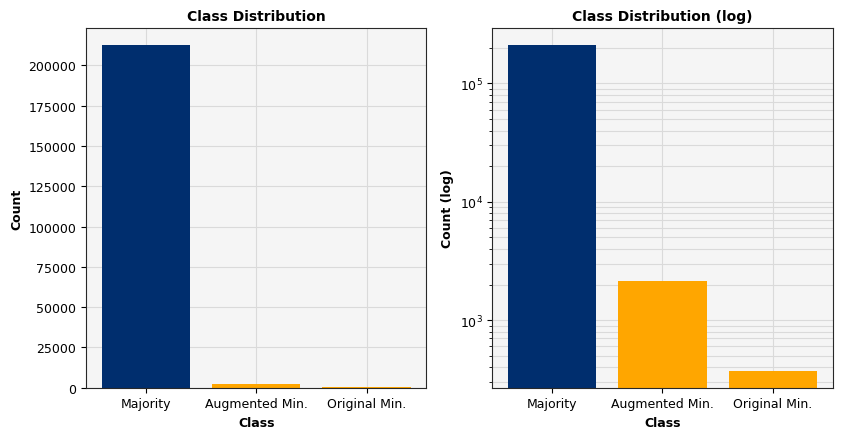

In [ ]:
# class balance visualisation code:

# only visualises new distributions if augmentation has occured
if augment_data == True:

    # class data
    class_majority = y_class[0]
    augmented_minority = y_class[1]
    original_minority = len(y_minority)

    # graph plot area
    plot_size(1,2)
    fig, ax = plt.subplots(1, 2, figsize=(plot_size(1, 2)))

    # class distribution graphs with and without log scale
    plot_bar(class_majority,
            augmented_minority,
            original_minority,
            ax[0],
            "Class Distribution",
            ["Majority", "Augmented Min.", 'Original Min.'],
            "Class",
            "Count")

    plot_bar(class_majority,
            augmented_minority,
            original_minority,
            ax[1],
            "Class Distribution (log)",
            ["Majority", "Augmented Min.", 'Original Min.'],
            "Class",
            "Count (log)",
            log_scale=True,)


# augmentation disabled code:
else:
    print('Data augmentation has been disabled and results cannot be displayed')

**Observations:**
* Minority increase is noticable but not excessive.


### | 5.2 Export Data

In [ ]:
# data exporting code:

# export training data to pickle format
X_augment.to_pickle(drive_prefix + "data/augmented/X_augmented.pkl")
y_augment.to_pickle(drive_prefix + "data/augmented/y_augmented.pkl")